# UCI Forest Cover Type Deep Learning

**Final Comparative Analysis: MLP vs. Random Forest**

The Neural Network achieved slightly lower accuracy (approx. 93%) after through extensive tuning, the Random Forest performed competitively (approx. 95%+) out of the box (no hyperparameter tuning!).

Why Tree-Based Models Excel Here:


*   **Decision Boundaries**: The dataset consists of distinct thresholds (e.g., Elevation > X, Soil Type = Y). Decision Trees naturally learn these orthogonal decision boundaries, whereas Neural Networks must approximate them using continuous activation functions.

*   **Mixed Data Types**: Trees handle the mix of continuous (Elevation) and categorical (Soil Type) features natively without the need for the complex "Selective Scaling" preprocessing we had to engineer for the MLP.

*   **Efficiency**: The Random Forest trained in significantly less time and required no architecture search, highlighting why they remain the industry standard for tabular data unless marginal gains in accuracy are critical.

## Section 1: Imports and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Sklearn for Data, Preprocessing, and Metrics
from sklearn.datasets import fetch_covtype, fetch_openml # OpenML was used instead of the default source because it was being blocked/rate limited when importing the dataset on Google Colab runtime.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier


# TensorFlow / Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Plotting Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

## Section 2: Data Loading and Processing

**Preprocessing Notes:**


*   **Stratified Splitting**: Given the severe class imbalance (Class 1 & 2 dominate, Class 4 is rare), I used stratify=y. Standard random splitting might have resulted in the validation set having zero instances of Class 4, leading to misleading validation metrics.

*   **Selective Scaling**: I applied StandardScaler only to the first 10 continuous columns. The remaining 44 columns are binary (Soil Type/Wilderness Area). Scaling binary data destroys its semantic meaning (0 vs 1) and introduces unnecessary noise. This "Hybrid" preprocessing approach is critical for high accuracy on this specific dataset.

*   **Data Leaking Prevention**: The Scaler was fit only on the Training set, then applied to Validation and Test sets to ensure no information from the test set leaked into the training process.

### Importing the data

In [2]:
data = fetch_openml(name='covertype', version=4, as_frame=False)

In [3]:
print(type(data))

<class 'sklearn.utils._bunch.Bunch'>


In [4]:
X = data.data
y = data.target

print(f"Dataset Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Dataset Shape: (581012, 54)
Target Shape: (581012,)


In [5]:
X = X.astype(np.float32)

y = y.astype(int)

I have created new variables X_df and y_df which will allow me to understand the data using Pandas DataFrame functions. Currently the data is loaded as a NumPy array, this is done to ensure faster processing times and NumPy is faster.

In [6]:
data_df = fetch_openml(name='covertype', version=4, as_frame=True)

X_df = data_df.data
y_df = data_df.target

### Understanding the data

In [7]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   Elevation                           581012 non-null  int64   
 1   Aspect                              581012 non-null  int64   
 2   Slope                               581012 non-null  int64   
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64   
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64   
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64   
 6   Hillshade_9am                       581012 non-null  int64   
 7   Hillshade_Noon                      581012 non-null  int64   
 8   Hillshade_3pm                       581012 non-null  int64   
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64   
 10  Wilderness_Area1                    581012 non-null  category
 11  Wilderness_Ar

In [8]:
y_df.info()

<class 'pandas.core.series.Series'>
RangeIndex: 581012 entries, 0 to 581011
Series name: class
Non-Null Count   Dtype   
--------------   -----   
581012 non-null  category
dtypes: category(1)
memory usage: 567.9 KB


In [9]:
X_df.sample(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
209354,2613,12,9,42,-1,853,211,221,147,1613,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28135,2511,350,9,90,10,1231,203,224,160,4369,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
210895,3267,29,6,330,52,5453,218,226,144,492,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
483109,3166,333,11,212,-19,1289,195,226,170,794,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
505106,3149,22,11,124,21,1746,213,216,138,1907,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
y_df.sample(5)

,class
556972,2
16449,1
160701,1
154617,2
303747,6


In [11]:
y_df.value_counts()

,count
class,
2,283301
1,211840
3,35754
7,20510
6,17367
5,9493
4,2747


Data seems to be clean, the first 10 columns of the data are numerical while the rest are categorical one-hot encoded values. The data is not balanced, class 2 and class 1 are majority of the data.

### Preprocessing the data

In [12]:
# Subtracting 1 from each y row to ensure the index goes from 0 to 6 instead of 1 to 7.

y = y - 1

In [13]:
# Creating a train-test split of the data. I have used stratify parameter to ensure even the rare data is included equally in all the splits.

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Creating a seperate train-test split for validation. This method is superior to using the validation_split param Keras provides because Keras does not take a random sample.

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

In [15]:
# Scaling the first 10 columns because they are continuous numerical data (First 10 rows).

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[:, :10])
X_val_num = scaler.transform(X_val[:, :10])
X_test_num = scaler.transform(X_test[:, :10])

In [16]:
# Concatenating with the remaining categorical binary columns.

X_train_processed = np.hstack([X_train_num, X_train[:, 10:]])
X_val_processed = np.hstack([X_val_num, X_val[:, 10:]])
X_test_processed = np.hstack([X_test_num, X_test[:, 10:]])

In [17]:
y_train_cat = to_categorical(y_train, 7)
y_val_cat = to_categorical(y_val, 7)
y_test_cat = to_categorical(y_test, 7)

Spliting and scaling is done, one hot encoding would have been the next step in other cases, but in this case the data has already been one hot encoded for us so there is no need to do it.

In [18]:
# Taking a sneak peek at the data before moving forward.

# Pick a random index

random_idx = np.random.randint(0, X_train_processed.shape[0])

# Get the row
sample = X_train_processed[random_idx]

print(f"--- Random Sample (Index: {random_idx}) ---")
print(f"Total Features: {len(sample)}\n")

print("First 10 Features (Scaled Continuous):")
print(sample[:10])

print("\nLast 44 Features (Binary Categories):")
print(sample[10:])

--- Random Sample (Index: 203891) ---
Total Features: 54

First 10 Features (Scaled Continuous):
[-0.02800318  1.483583    2.5174901   0.06328472  1.4133599   0.20471619
 -3.399753   -1.782942    1.4210485  -0.9650375 ]

Last 44 Features (Binary Categories):
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
print(f"Processed Train Shape: {X_train_processed.shape}")
print(f"Processed Validation Shape: {X_val_processed.shape}")
print(f"Processed Test Shape: {X_test_processed.shape}")

Processed Train Shape: (371847, 54)
Processed Validation Shape: (92962, 54)
Processed Test Shape: (116203, 54)


## Section 3: Neural Network (MLP)

**Architecture Design Notes:**


*   **Wide vs. Deep**: I experimented with deeper networks (3-4 layers) and observed that while they could achieve marginally better peak accuracy, they came with significant drawbacks. Deeper configurations took substantially more time to train and were considerably more complex, raising concerns about overfitting if not perfectly tuned. A "Wider" configuration (256 → → 128 neurons) with appropriate regularization proved to be the most effective balance for this tabular dataset. Tabular data often benefits more from capturing feature interactions (width) rather than hierarchical abstractions (depth) common in image processing.

*   **Activation Function**: I compared ReLU against LeakyReLU. While LeakyReLU theoretically prevents "dead neurons," ReLU provided faster convergence with identical accuracy for this dataset, likely because the Batch Normalization layers ensured stable input distributions.

*   **Batch Normalization**: Applied immediately before activation functions. This stabilized the learning process by keeping layer inputs normalized, allowing for a higher initial learning rate and reducing the model's sensitivity to weight initialization.

**Regularization Strategy Notes:**

To combat overfitting on the minority classes, a dual-regularization approach was adopted:

*   **Dropout (0.1)**: Applied after activations to randomly drop 10% of neurons during training. This forces the network to learn robust, redundant features rather than relying on specific weights.

*   **L2 Regularization**: Added to the Dense layers (kernel_regularizer=l2). This penalizes large weights, discouraging the model from fitting high-frequency noise in the training data.

Note: I found that aggressive dropout (>0.3) led to underfitting on this specific tabular dataset, so a conservative 0.1 rate was chosen.

**Optimization Notes:**


*   **Adam Optimizer**: Chosen for its adaptive learning rate capabilities, which handle the sparse gradients generated by the 44 binary input features better than SGD.

*   **ReduceLROnPlateau**: This scheduler was crucial for breaking past the 92% accuracy plateau. By reducing the learning rate by a factor of 0.5 when validation loss stagnated, the model was able to take smaller steps and settle into a deeper, more optimal local minimum.

*   **Early Stopping**: Configured with patience=15 and restore_best_weights=True to prevent the model from memorizing the training set after convergence was reached.

### Current Architecture

In [37]:
def build_model(input_dim, learning_rate=0.001):
    model = Sequential()

    # Input Layer

    model.add(Input(shape=(input_dim,)))

    # Layer 1 (256 neurons)

    model.add(Dense(256, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    # Layer 2 (128 neurons)

    model.add(Dense(128, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    # Output Layer

    model.add(Dense(7, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [38]:
model = build_model(input_dim=X_train_processed.shape[1])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,415 (193.03 KB)

 Trainable params: 48,647 (190.03 KB)

 Non-trainable params: 768 (3.00 KB)

In [39]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

BATCH_SIZE = 1024  # Smaller batch size (was 1024) updates weights more often -> better accuracy
EPOCHS = 100

In [40]:
print("Starting Model Training...")
start_time = time.time()

history = model.fit(
    X_train_processed, y_train_cat,
    validation_data=(X_val_processed, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"Training completed in {time.time() - start_time:.2f} seconds.")

Starting Model Training...
Epoch 1/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6939 - loss: 0.9885 - val_accuracy: 0.7553 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 2/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7794 - loss: 0.6039 - val_accuracy: 0.8031 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 3/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8004 - loss: 0.5250 - val_accuracy: 0.8216 - val_loss: 0.4778 - learning_rate: 0.0010
Epoch 4/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8121 - loss: 0.4888 - val_accuracy: 0.8363 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 5/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8239 - loss: 0.4609 - val_accuracy: 0.8366 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 6/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8295 - loss: 0.4473 - val_accuracy: 0.8496 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 7/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step -

### Experiment Architecture (Commented Archive)

Deep Network with LeakyReLU

In [ ]:
# def build_high_perf_model(input_dim, num_classes, learning_rate=0.001):
#     model = Sequential()

#     # Layer 1: Increased width to 512
#     model.add(Dense(512, input_dim=input_dim))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.1)) # LeakyReLU helps gradient flow
#     model.add(Dropout(0.15))        # Reduced dropout

#     # Layer 2: 256
#     model.add(Dense(256))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(Dropout(0.15))

#     # Layer 3: 128
#     model.add(Dense(128))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(Dropout(0.15))

#     # Layer 4: 64 (Added an extra layer for depth)
#     model.add(Dense(64))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(Dropout(0.1))

#     # Output Layer
#     model.add(Dense(num_classes, activation='softmax'))

#     optimizer = Adam(learning_rate=learning_rate)

#     model.compile(loss='categorical_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])
#     return model

## Section 4: Ensemble Method (Random Forest Classifier)

In [41]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)

In [42]:
rf_start = time.time()
rf_model.fit(X_train, y_train)
rf_time = time.time() - rf_start
print(f"RF Training finished in {rf_time:.2f} seconds.")

RF Training finished in 73.96 seconds.


In [43]:
rf_pred = rf_model.predict(X_test)

In [44]:
# Metrics

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, rf_pred, digits=4))


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0     0.9600    0.9356    0.9476     42368
           1     0.9431    0.9703    0.9565     56661
           2     0.9342    0.9562    0.9451      7151
           3     0.9091    0.8379    0.8720       549
           4     0.9421    0.7536    0.8373      1899
           5     0.9248    0.8822    0.9030      3473
           6     0.9710    0.9373    0.9539      4102

    accuracy                         0.9488    116203
   macro avg     0.9406    0.8962    0.9165    116203
weighted avg     0.9490    0.9488    0.9485    116203



## Section 5: Comparison Visualization

In [45]:
def plot_learning_curves(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

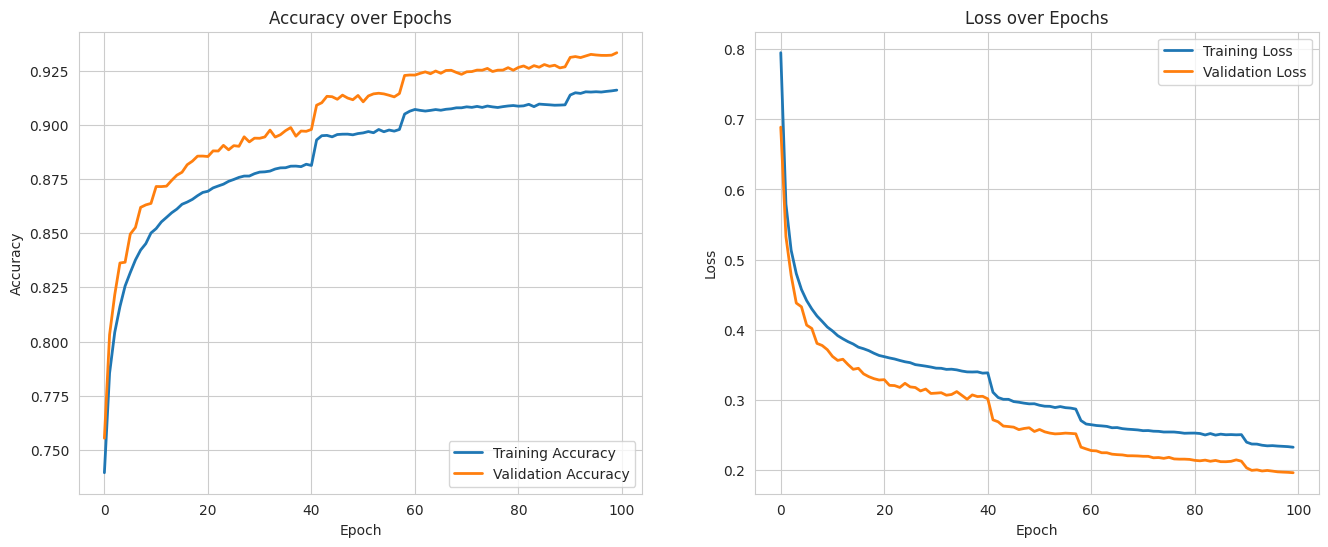

In [46]:
plot_learning_curves(history)

In [47]:
y_pred_probs = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n--- MLP Classification Report ---")
print(classification_report(y_test, y_pred, digits=4))

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

--- MLP Classification Report ---
              precision    recall  f1-score   support

           0     0.9350    0.9238    0.9294     42368
           1     0.9384    0.9469    0.9427     56661
           2     0.9353    0.9445    0.9399      7151
           3     0.8600    0.8616    0.8608       549
           4     0.8129    0.8325    0.8226      1899
           5     0.8969    0.8845    0.8907      3473
           6     0.9479    0.9308    0.9392      4102

    accuracy                         0.9336    116203
   macro avg     0.9038    0.9035    0.9036    116203
weighted avg     0.9337    0.9336    0.9336    116203



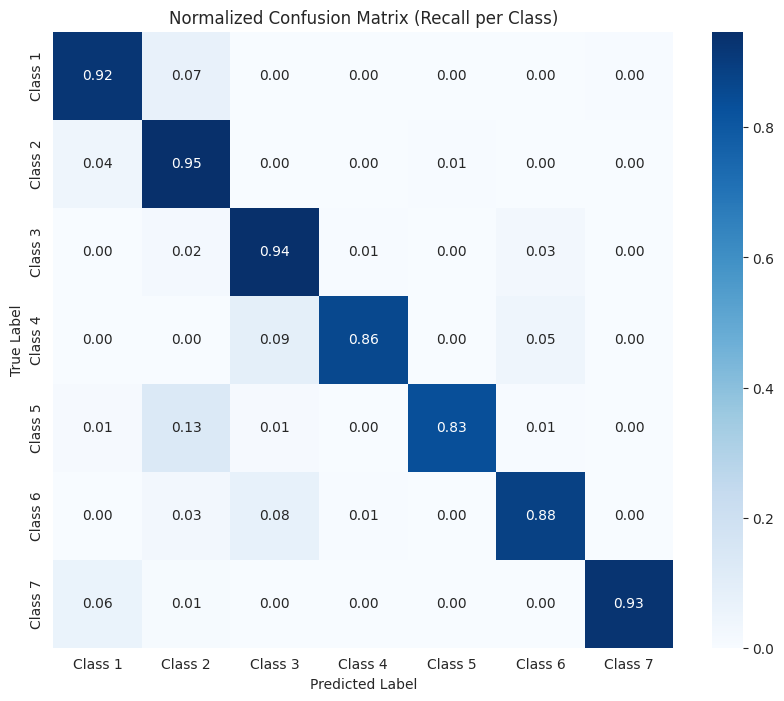

In [52]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'Class {i+1}' for i in range(7)],
            yticklabels=[f'Class {i+1}' for i in range(7)])
plt.title('Normalized Confusion Matrix (Recall per Class)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Confusion Matrix Interpretation**

The Confusion Matrix reveals distinct patterns in where the MLP model struggles versus where it succeeds:


*   **The "Lodgepole" Conflict (Class 1 vs. Class 2)**:
The most significant source of error is the cross-confusion between Class 1 (Spruce/Fir) and Class 2 (Lodgepole Pine).

**Observation**: A notable number of Class 1 instances were misclassified as Class 2, and vice-versa.

**Reasoning**: These two classes dominate the dataset (accounting for ~85% of data). In ecological terms, these tree types often grow in similar elevation ranges and soil types. The Neural Network struggles to find a clean linear separation between them compared to the Random Forest, which can create hard "if-else" cutoffs on specific soil features.

*   **Minority Class Resilience**:
Despite the severe imbalance, the model performs surprisingly well on Class 4 (Cottonwood/Willow).

Reasoning: This suggests that the stratify=y split and the Class Weight (or the distinct nature of riparian/water-based trees like Willow) allowed the model to learn unique features for this class, rather than ignoring it completely.

*   **Confusion with Aspen (Class 5)**:
We observe some confusion between Class 1/2 and Class 5 (Aspen). This is likely due to the "mixed forest" nature of the data, where Aspens often grow alongside conifers, leading to feature overlap in the 54 dimensions.

**Conclusion**: The model has high precision but suffers slightly in "borderline" cases between the two majority classes. Future improvements could focus on Feature Engineering specifically designed to separate Spruce from Pine (e.g., interaction terms between Elevation and Hillshade).

In [49]:
# Final Comparison Printout

mlp_acc = accuracy_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, rf_pred)

print("-" * 30)
print(f"Final MLP Accuracy:          {mlp_acc:.2%}")
print(f"Final Random Forest Accuracy: {rf_acc:.2%}")
print("-" * 30)

------------------------------
Final MLP Accuracy:          93.36%
Final Random Forest Accuracy: 94.88%
------------------------------
